In [1]:
%load_ext nb_black

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import altair as alt
import json

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
data = pd.read_csv("./data/archon_arcana_weekly_20210619.csv", thousands=",")
data["Week_nr"] = data.index
data = data[data.Week_nr > 0]  # ignore first line which is day 3, start with week 1
model_data = data[["Week_nr", "Total"]].copy()
model_data[["Total_scaled"]] = (
    model_data["Total"] / 10000
)  # PyMC3 doesn't seem to like very large numbers, so lets bring them down a few orders of magnitude
model_data

,Week_nr,Total,Total_scaled
1,1,158016,15.8016
2,2,218733,21.8733
3,3,268026,26.8026
4,4,311895,31.1895
5,5,358098,35.8098
...,...,...,...
130,130,2308213,230.8213
131,131,2332833,233.2833
132,132,2346868,234.6868
133,133,2359112,235.9112


<IPython.core.display.Javascript object>

## What if COVID-19 didn't happen, how many decks would have been sold

We'll take model 5 from the previous notebook and add a twist, rather than including the start of COVID-19 in the model, we'll make it a fixed value using ```pm.Data``` this will allow us to change the value later on (to something in the future) so we can create a model that would behave as if the pandemic didn't happen.

In [5]:
len_observed = len(model_data)
with pm.Model() as model_5:
    # priors
    sigma = pm.Exponential("sigma", lam=1.0)  # Sigma for likelihood function

    # here we set the start of covid manually (based on previous notebook)
    # this way it can be changed after fitting the model
    covid_start = pm.Data("covid_start", 68)

    # We know from the previous that mu before and during covid should be around 0.8 and 3.0 respectively
    # Sigma is reduced here not to diverge to far from these values
    BoundNormal_0 = pm.Bound(pm.Normal, lower=0)
    weekly_registrations_covid = BoundNormal_0(
        "weekly_registrations_covid", mu=0.8, sigma=0.5
    )
    weekly_registrations_precovid = BoundNormal_0(
        "weekly_registrations_precovid", mu=3, sigma=0.5
    )

    weekly_registrations_base = pm.math.switch(
        covid_start >= model_data.Week_nr,
        weekly_registrations_precovid,
        weekly_registrations_covid,
    )

    # Model extra registrations due to shifting interest (like new sets being released)
    # The interest factor is calculated on a weekly basis
    decay_factor = pm.Exponential("decay_factor", lam=1.0)

    cota_interest = pm.HalfNormal("cota_interest", sigma=2)
    aoa_interest = pm.HalfNormal("aoa_interest", sigma=2)
    wc_interest = pm.HalfNormal("wc_interest", sigma=2)
    mm_interest = pm.HalfNormal("mm_interest", sigma=2)
    dt_interest = pm.HalfNormal("dt_interest", sigma=2)

    interest_decayed = [cota_interest]

    for i in range(len_observed - 1):
        new_element = interest_decayed[i] * decay_factor
        if i == 27:
            new_element += aoa_interest
        if i == 50:
            new_element += wc_interest
        if i == 85:
            new_element += mm_interest
        if i == 126:
            new_element += dt_interest
        interest_decayed.append(new_element)

    # there were 150k decks registered the first week, that is the initial value
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], 15)

    outputs, _ = theano.scan(
        fn=lambda t, y, ws, intfac: tt.set_subtensor(
            y[t], (ws[t] * (1 + intfac[t])) + y[t - 1]
        ),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=[weekly_registrations_base, interest_decayed],
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

    # posterior
    trace_5 = pm.sample(1000, cores=10, chains=4, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [dt_interest, mm_interest, wc_interest, aoa_interest, cota_interest, decay_factor, weekly_registrations_precovid, weekly_registrations_covid, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1115 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9051694983135794, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

In [25]:
from pymc3_altair import plot_fit_altair

with model_5:
    pm.set_data({"covid_start": 68})

chart_with_covid = plot_fit_altair(model_5, trace_5, model_data)
chart_with_covid

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [26]:
with model_5:
    pm.set_data({"covid_start": 500})

chart_without_covid = plot_fit_altair(model_5, trace_5, model_data)
chart_without_covid

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [27]:
combined = chart_with_covid.properties(
    title="Final model with COVID-19"
) | chart_without_covid.properties(title="Final model without COVID-19")
combined.save("./altair_output/covid_start_data.json")
combined

alt.HConcatChart(...)

<IPython.core.display.Javascript object>

This is by far the best way to change a model, but it doesn't offer much flexibility. In this case it is very likely that releasing a new set during COVID will have a very different effect on sales than under normal circumstances. Hence the impact of the last two sets might be exagerated. This would be an optimistic model, though it would be nice to be able to model what would happen in case Mass Mutation and Dark Tidings performed as Worlds Collide (which had the lowest impact on sales). This requires another approach (I think let me know if there is an elegant solution to this).

Another method is to create a new model, with priors based on the results from the previous one, excluding the COVID-19 factor. Rather than tracing it to get posteriors, we'll use the ```prior_predictive()``` to run the model with these parameters to see what comes out at the end. This allows for some additional flexibility the latter option didn't provide

We'll use two versions here, an optimistic one, where the interest in Mass Mutation (mm_interest) and Dark Tidings (dt_interest) from model_5 is used. However, as these were released during COVID, it might not be an accurate representation how they would have impacted sales during normal times. Therefore a pessimistic model, where MM and DT performed the same as the worst previous set (Worlds Collide) is build as well.

In [28]:
with pm.Model() as model_6:
    # priors
    sigma = pm.Normal("sigma", mu=1.17, sigma=0.07)  # Sigma for likelihood function

    weekly_registrations = pm.Normal("weekly_registrations", mu=1.55, sigma=0.06)

    # Model extra registrations due to shifting interest (like new sets being released)
    # The interest factor is calculated on a weekly basis
    decay_factor = pm.Normal("decay_factor", mu=0.84, sigma=0.01)

    cota_interest = pm.Normal("cota_interest", mu=4.11, sigma=0.19)
    aoa_interest = pm.Normal("aoa_interest", mu=1.7, sigma=0.16)
    wc_interest = pm.Normal("wc_interest", mu=0.95, sigma=0.13)
    mm_interest = pm.Normal("mm_interest", mu=3.18, sigma=0.31)
    dt_interest = pm.Normal("dt_interest", mu=3.02, sigma=0.35)

    interest_decayed = [cota_interest]

    for i in range(len_observed - 1):
        new_element = interest_decayed[i] * decay_factor
        if i == 27:
            new_element += aoa_interest
        if i == 50:
            new_element += wc_interest
        if i == 85:
            new_element += mm_interest
        if i == 126:
            new_element += dt_interest
        interest_decayed.append(new_element)

    # there were 150k decks registered the first week, that is the initial value
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], 15)

    outputs, _ = theano.scan(
        fn=lambda t, y, intfac: tt.set_subtensor(
            y[t], (weekly_registrations * (1 + intfac[t])) + y[t - 1]
        ),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=[interest_decayed],
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

<IPython.core.display.Javascript object>

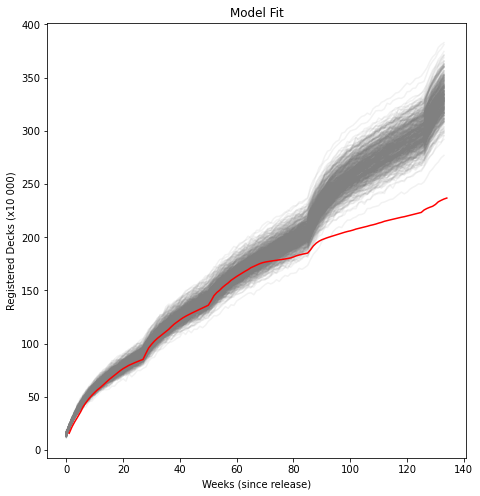

<IPython.core.display.Javascript object>

In [29]:
def plot_prior_predictor(m, df):
    with m:
        prior_predictor = pm.sample_prior_predictive()

    fig, (ax1) = plt.subplots(1, 1, figsize=(7.5, 8))
    ax1.plot(prior_predictor["y"].T, color="0.5", alpha=0.1)
    ax1.plot(df.Total_scaled, color="red", alpha=1)
    ax1.set(
        xlabel="Weeks (since release)",
        ylabel="Registered Decks (x10 000)",
        title="Model Fit",
    )

    plt.show()


plot_prior_predictor(model_6, model_data)

In [35]:
from pymc3_altair import plot_prior_predictor_altair


chart_prediction_1 = plot_prior_predictor_altair(model_6, model_data)
chart_prediction_1.properties(width="container").save(
    "./altair_output/prediction_1.json"
)
chart_prediction_1

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [31]:
with pm.Model() as model_7:
    # priors
    sigma = pm.Normal("sigma", mu=1.17, sigma=0.07)  # Sigma for likelihood function

    weekly_registrations = pm.Normal("weekly_registrations", mu=1.55, sigma=0.06)

    # Model extra registrations due to shifting interest (like new sets being released)
    # The interest factor is calculated on a weekly basis
    decay_factor = pm.Normal("decay_factor", mu=0.84, sigma=0.01)

    cota_interest = pm.Normal("cota_interest", mu=4.11, sigma=0.19)
    aoa_interest = pm.Normal("aoa_interest", mu=1.7, sigma=0.16)
    wc_interest = pm.Normal("wc_interest", mu=0.95, sigma=0.13)
    mm_interest = pm.Normal(
        "mm_interest", mu=0.95, sigma=0.13
    )  # Maybe people's buying behaviour responds differently to
    dt_interest = pm.Normal(
        "dt_interest", mu=0.95, sigma=0.13
    )  # the release of a new set, worst case scenario is setting these very low

    interest_decayed = [cota_interest]

    for i in range(len_observed - 1):
        new_element = interest_decayed[i] * decay_factor
        if i == 27:
            new_element += aoa_interest
        if i == 50:
            new_element += wc_interest
        if i == 85:
            new_element += mm_interest
        if i == 126:
            new_element += dt_interest
        interest_decayed.append(new_element)

    # there were 150k decks registered the first week, that is the initial value
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], 15)

    outputs, _ = theano.scan(
        fn=lambda t, y, intfac: tt.set_subtensor(
            y[t], (weekly_registrations * (1 + intfac[t])) + y[t - 1]
        ),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=[interest_decayed],
        n_steps=len_observed - 1,
    )

    total_registrations = pm.Deterministic("total_registrations", outputs[-1])

    # Likelihood
    likelihood = pm.Normal(
        "y", mu=total_registrations, sigma=sigma, observed=model_data.Total_scaled
    )

<IPython.core.display.Javascript object>

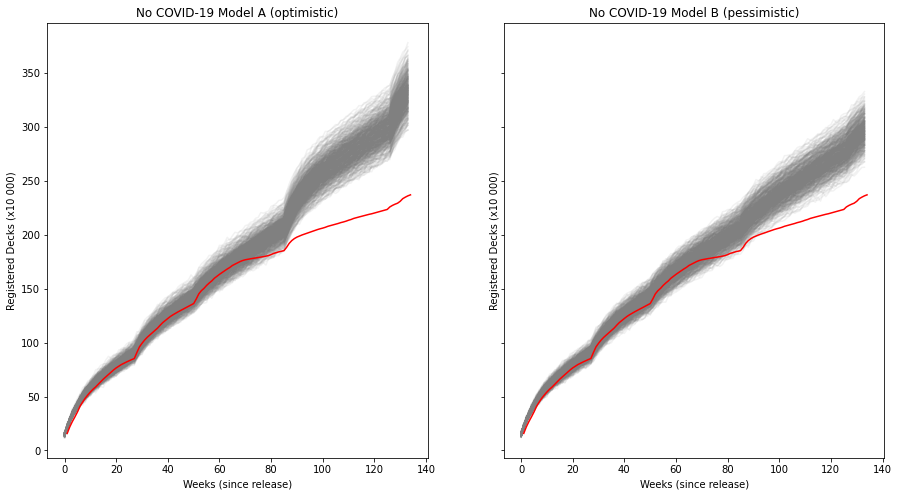

<IPython.core.display.Javascript object>

In [32]:
def plot_prior_predictor_side_by_side(m, m2, df):
    with m:
        prior_predictor = pm.sample_prior_predictive()
    with m2:
        prior_predictor2 = pm.sample_prior_predictive()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
    ax1.plot(prior_predictor["y"].T, color="0.5", alpha=0.1)
    ax1.plot(df.Total_scaled, color="red", alpha=1)
    ax1.set(
        xlabel="Weeks (since release)",
        ylabel="Registered Decks (x10 000)",
        title="No COVID-19 Model A (optimistic)",
    )

    ax2.plot(prior_predictor2["y"].T, color="0.5", alpha=0.1)
    ax2.plot(df.Total_scaled, color="red", alpha=1)
    ax2.set(
        xlabel="Weeks (since release)",
        ylabel="Registered Decks (x10 000)",
        title="No COVID-19 Model B (pessimistic)",
    )

    plt.show()


plot_prior_predictor_side_by_side(model_6, model_7, model_data)

In [33]:
chart_prediction_2 = plot_prior_predictor_altair(model_7, model_data)
chart_prediction_2.properties(width="container").save(
    "./altair_output/prediction_2.json"
)
chart_prediction_2

alt.LayerChart(...)

<IPython.core.display.Javascript object>

In [34]:
combined = chart_prediction_1.properties(
    title="No COVID-19 (Optimistic model)"
) | chart_prediction_2.properties(title="No COVID-19 (Pessimistic model)")
combined.save("./altair_output/combined_predictions.json")
combined

alt.HConcatChart(...)

<IPython.core.display.Javascript object>

So the optimistic model predicts that in a universe without COVID-19, there likely would have been over 3 million registered decks by now. Going as high up as 3.7 million, this would mean there would have been roughly 0.5 to 1.5 million more decks registered over the last 18 or so months.

The pessimistic model is more modest about those numbers though the total number of registrations would still have been getting very close to 3 million, with roughly 0.5 to 1 million additional decks sold since the first lockdowns due to COVID.

However, here we start the model from the very start. This isn't necessary as we know exactly how many decks were sold prior to the lockdown. So we don't have to include all the uncertainty before that point when forecasting sales in a COVID-19 free world.